In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [88]:
def split_data(arr,dim=[8,8]):
    arr = np.array(np.split(arr,dim[0]))
    res = []
    for data in arr:
        res.extend(np.split(data,dim[1],axis=1))
    return np.array(res)

def reconstruct_data(arr,dim_pad=(256,256),dim_orig=(256,256)):
    x_stride = dim_pad[1]/32
    y_stride = dim_pad[0]/32
    out = np.zeros(dim_pad)
    count=0
    for y in range(y_stride):
        for x in range(x_stride):
            x_start = 32*x
            x_end = 32+x_start
            y_start = 32*y
            y_end = 32+y_start
            out[y_start:y_end,x_start:x_end] = arr[count,:,:,0]
            count+=1
    return out[:dim_orig[0],:dim_orig[1]]

def denoise(img, weight=0.1, eps=1e-3, num_iter_max=200):
    """Perform total-variation denoising on a grayscale image.
    
    Parameters
    ----------
    img : array
        2-D input data to be de-noised.
    weight : float, optional
        Denoising weight. The greater `weight`, the more de-noising (at
        the expense of fidelity to `img`).
    eps : float, optional
        Relative difference of the value of the cost function that determines
        the stop criterion. The algorithm stops when:
            (E_(n-1) - E_n) < eps * E_0
    num_iter_max : int, optional
        Maximal number of iterations used for the optimization.

    Returns
    -------
    out : array
        De-noised array of floats.
    
    Notes
    -----
    Rudin, Osher and Fatemi algorithm.
    """
    u = np.zeros_like(img)
    px = np.zeros_like(img)
    py = np.zeros_like(img)
    
    nm = np.prod(img.shape[:2])
    tau = 0.125
    
    i = 0
    while i < num_iter_max:
        u_old = u
        
        # x and y components of u's gradient
        ux = np.roll(u, -1, axis=1) - u
        uy = np.roll(u, -1, axis=0) - u
        
        # update the dual variable
        px_new = px + (tau / weight) * ux
        py_new = py + (tau / weight) * uy
        norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
        px = px_new / norm_new
        py = py_new / norm_new

        # calculate divergence
        rx = np.roll(px, 1, axis=1)
        ry = np.roll(py, 1, axis=0)
        div_p = (px - rx) + (py - ry)
        
        # update image
        u = img + weight * div_p
        
        # calculate error
        error = np.linalg.norm(u - u_old) / np.sqrt(nm)
        
        if i == 0:
            err_init = error
            err_prev = error
        else:
            # break if error small enough
            if np.abs(err_prev - error) < eps * err_init:
                break
            else:
                e_prev = error
                
        # don't forget to update iterator
        i += 1

    return u

def check_inverted(testset):
    out = {}
    for key in testset:
        arr = testset[key]
        curr_size = arr.shape[0]*arr.shape[1]*arr.shape[2]
        curr_max = np.amax(arr)
        curr_min = np.amin(arr)
    
        temp_bins = list(np.linspace(curr_min,curr_max,10))
        check = np.histogram(arr,bins=temp_bins)[0]
        if sum(check[8:])/float(curr_size)>0.1:
            print curr_max,curr_min
            out[key] = abs(255-arr)
            print "Inverting "+key
        else:
            out[key] = arr
    return out

In [89]:
test_path = "./data/stage1_test/"
records = os.listdir(test_path)

first = True
testset = {}
testset_im = {}
prior_shape = {}
post_shape = {}
for rec in records:
    subdir = test_path+rec+"/images/"
    subfile = os.listdir(subdir)
    name = subfile[0][:-4]
    print name
    if len(subfile)>1:
        print("Error, more than one image found")
    arr = np.average(cv2.imread(subdir+subfile[0]),axis=2)
    testset_im[name]=arr
    prior_shape[name]=arr.shape
    
    #Pad Array
    width_pad = 32-arr.shape[0]%32
    length_pad = 32-arr.shape[1]%32
    temp = np.zeros((arr.shape[0]+width_pad,arr.shape[1]+length_pad))
    temp[:arr.shape[0],:arr.shape[1]]=arr
    post_shape[name]=temp.shape
    
    #Denoise Array
    #temp = denoise(temp,weight=0.35)
    
    #Break into Grids
    N = ((arr.shape[0]+width_pad)/32)*((arr.shape[1]+length_pad)/32)
    im = split_data(temp,dim=[(arr.shape[0]+width_pad)/32,(arr.shape[1]+length_pad)/32]).reshape(N,32,32,1).astype('float32')
    testset[name]=im
    
    #Compute Mean and STD
    if first == True:
        out = im
        first = False
    else:
        out = np.concatenate((out,im),axis=0)
        
img_mean = np.mean(out,axis=0)
img_std  = np.std(out)

testset = check_inverted(testset)

#Normalize Test Set Data
testset_norm = {}
for key in testset:
    testset_norm[key] = (testset[key]-img_mean)/img_std

0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5
0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac
0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732
0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925
0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6
0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466
1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff
1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b
191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829
1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a
1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c
259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4
295682d9eb5acb5c1976a460c

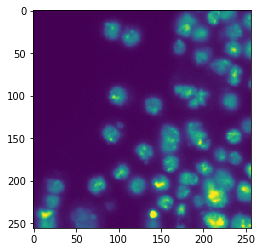

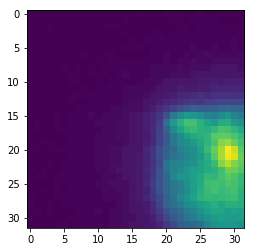

(81, 32, 32, 1)


In [90]:
plt.imshow(testset_im['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'])
plt.show()
temp = testset['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'][2,:,:,0]
plt.imshow(temp)
plt.show()
print testset['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'].shape

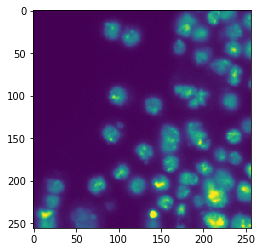

In [64]:
# Import Keras Model and Get Predictions
recon = reconstruct_data(testset['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808']
                         ,dim_pad=post_shape['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808']
                         ,dim_orig=prior_shape['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'])
plt.imshow(recon)
plt.show()

In [60]:
def check_inverted(testset):
    out = {}
    for key in testset:
        arr = testset[key]
        curr_size = arr.shape[0]*arr.shape[1]*arr.shape[2]
        curr_max = np.amax(arr)
        curr_min = np.amin(arr)
    
        temp_bins = list(np.linspace(curr_min,curr_max,10))
        check = np.histogram(arr,bins=temp_bins)[0]
        if sum(check[8:])/float(curr_size)>0.3:
            print curr_max,curr_min
            out[key] = abs(255-arr)
            print "Inverting "+key
        else:
            out[key] = arr
    return out


newset = check_inverted(testset)

252.0 0.0
Inverting c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb
255.0 0.0
Inverting 1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1
247.667 0.0
Inverting b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3
253.0 0.0
Inverting 3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26


In [91]:
from unet import get_unet

# Keras
model = get_unet()
model.load_weights("./weights.h5")
output = {}

for key in testset_norm:
    batch = testset_norm[key]
    prior = prior_shape[key]
    post = post_shape[key]
    print("Inputs: "+key)
    print("Batch: "+str(batch.shape))
    print("Priors: "+str(prior))
    print("Posts: "+str(post))
    masks = model.predict(batch,verbose=1)
    masks_recon = reconstruct_data(masks,dim_pad=post,dim_orig=prior)
    output[key] = masks_recon
    print masks_recon.shape

Inputs: 697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808
Batch: (81, 32, 32, 1)
Priors: (256, 256)
Posts: (288, 288)
81/81 [==============================] - 1s 12ms/step
(256, 256)
Inputs: c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb
Batch: (187, 32, 32, 1)
Priors: (524, 348)
Posts: (544, 352)
187/187 [==============================] - 2s 8ms/step
(524, 348)
Inputs: d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b
Batch: (81, 32, 32, 1)
Priors: (256, 256)
Posts: (288, 288)
81/81 [==============================] - 1s 8ms/step
(256, 256)
Inputs: e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258
Batch: (81, 32, 32, 1)
Priors: (256, 256)
Posts: (288, 288)
81/81 [==============================] - 1s 8ms/step
(256, 256)
Inputs: 1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c
Batch: (357, 32, 32, 1)
Priors: (512, 640)
Posts: (544, 672)
357/357 [==============================] - 3s 8ms/step
(512, 640)
Inputs: 

81/81 [==============================] - 1s 9ms/step
(256, 256)
Inputs: da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab
Batch: (374, 32, 32, 1)
Priors: (512, 680)
Posts: (544, 704)
374/374 [==============================] - 3s 9ms/step
(512, 680)
Inputs: 1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e
Batch: (357, 32, 32, 1)
Priors: (512, 640)
Posts: (544, 672)
357/357 [==============================] - 3s 9ms/step
(512, 640)
Inputs: 519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0
Batch: (81, 32, 32, 1)
Priors: (256, 256)
Posts: (288, 288)
81/81 [==============================] - 1s 9ms/step
(256, 256)
Inputs: d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896
Batch: (187, 32, 32, 1)
Priors: (520, 348)
Posts: (544, 352)
187/187 [==============================] - 2s 9ms/step
(520, 348)
Inputs: 9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2
Batch: (357, 32, 32, 1)
Priors: (512, 640)
Posts: (544, 672)
357/3

In [37]:
def clean_image(im,factor=0.2):
    x_stride = im.shape[0]/32
    y_stride = im.shape[1]/32
    
    total = 32**2
    
    for x in range(x_stride):
        for y in range(y_stride):
            x_start = x*32
            x_end = 32+x_start
            y_start = y*32
            y_end = 32+y_start
            temp = im[x_start:x_end,y_start:y_end]
            counts = np.histogram(temp,bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])[0]
            ratio = (sum(counts[4:7]))/float(total)
            if ratio > factor:
                im[x_start:x_end,y_start:y_end]=np.zeros((32,32))
            else:
                continue
    return im

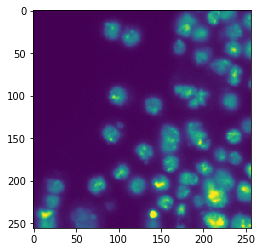

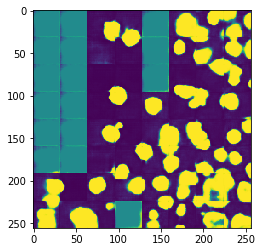

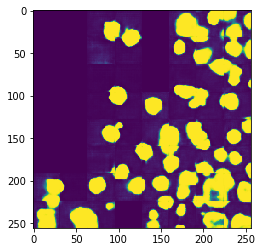

In [92]:
plt.imshow(testset_im['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'])
plt.show()

plt.imshow(output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'])
plt.show()


test1 = output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'][0:32,96:128]
test2 = output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'][0:32,0:32]

#plt.hist(test1,bins=30)
#plt.show()
#test = denoise(output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'],weight=0.35)
#plt.hist(test2,bins=30)
#plt.show()

temp = output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808']

test = clean_image(temp,factor=0.6)
plt.imshow(test)
plt.show()

In [93]:
output_denoise = {}
for key in output:
    temp = output[key]
    temp = clean_image(temp,factor=0.2)
    #temp[temp<0.5]=0
    #temp[temp>=0.5]=1
    output_denoise[key]=temp

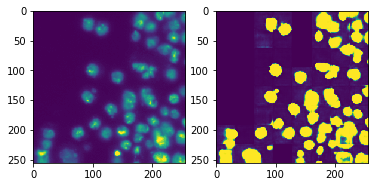

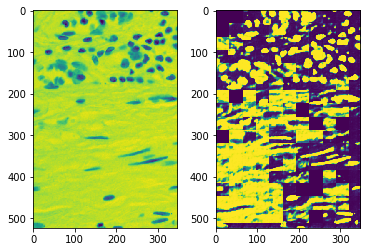

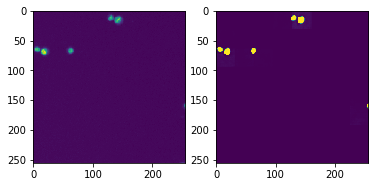

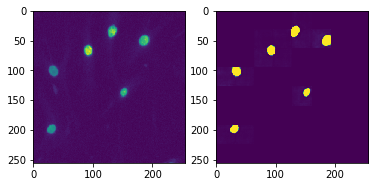

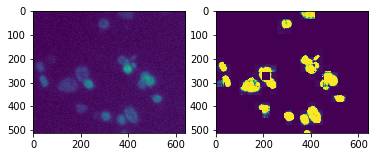

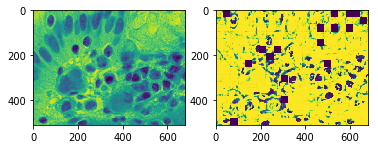

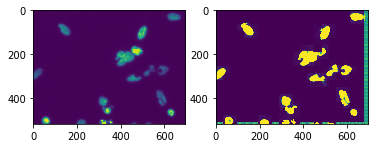

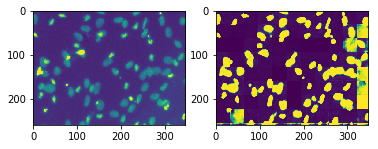

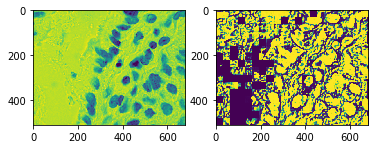

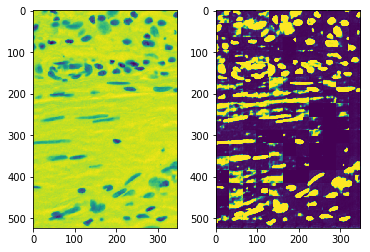

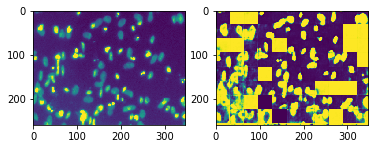

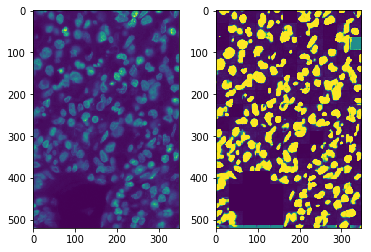

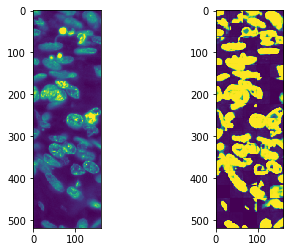

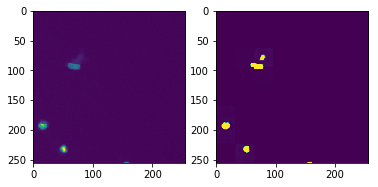

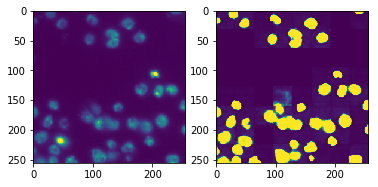

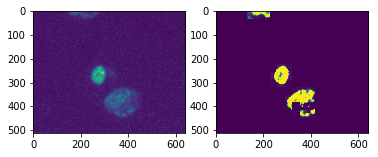

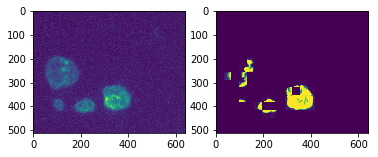

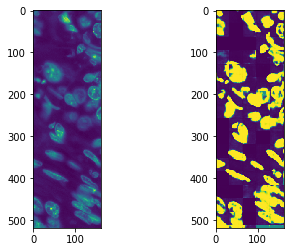

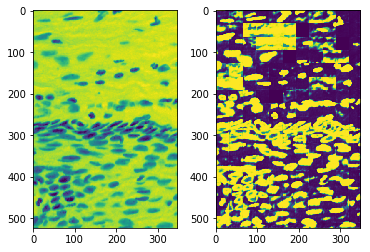

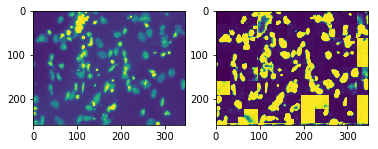

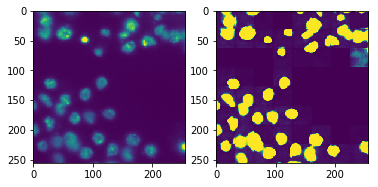

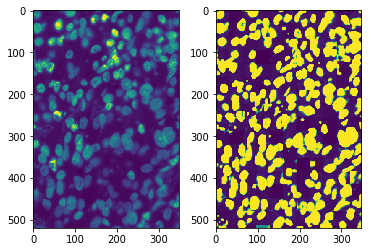

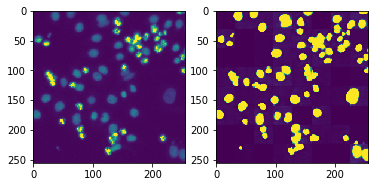

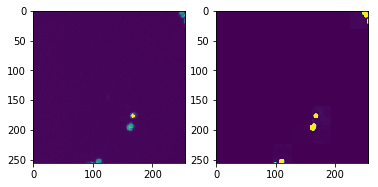

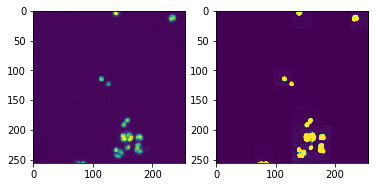

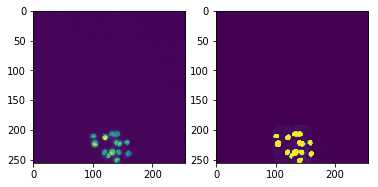

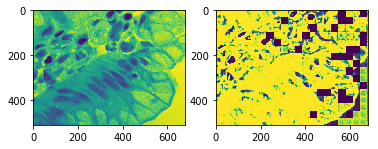

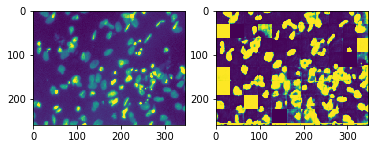

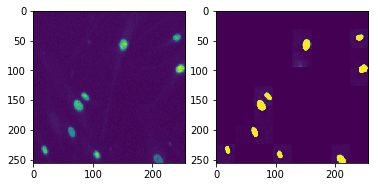

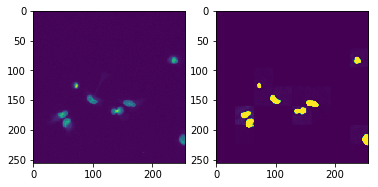

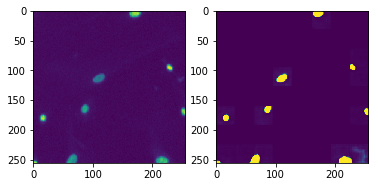

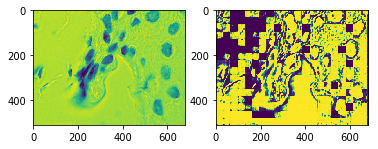

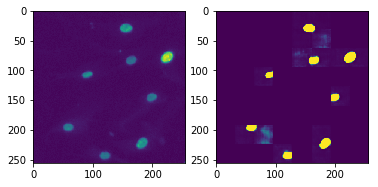

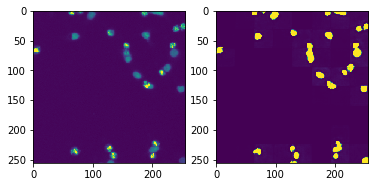

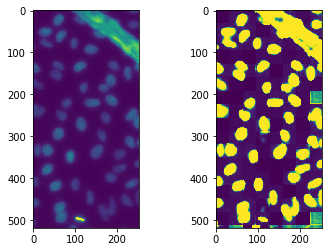

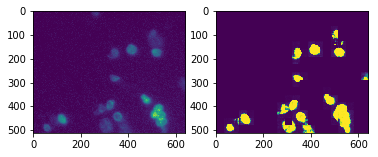

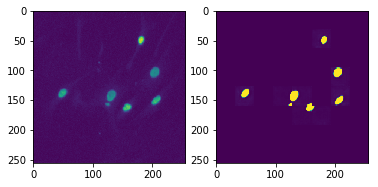

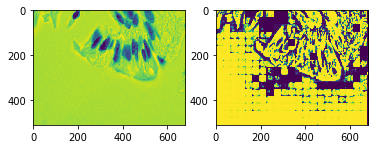

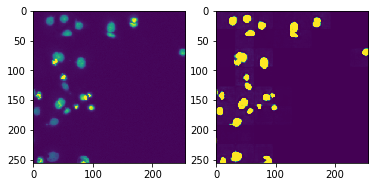

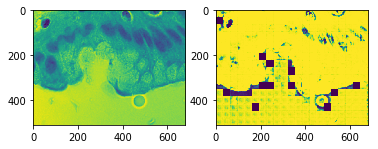

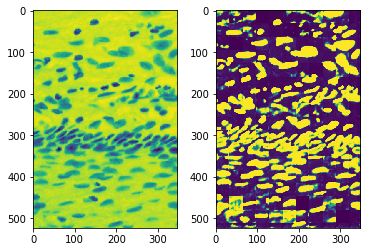

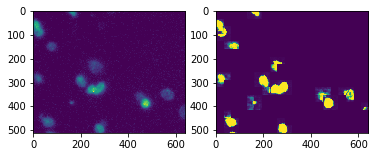

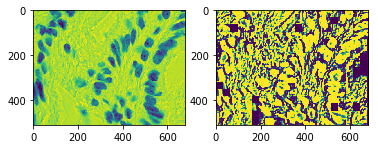

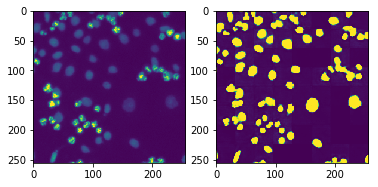

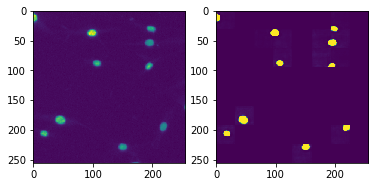

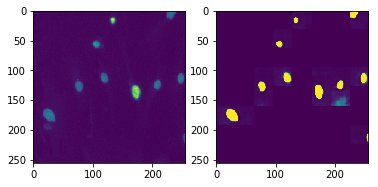

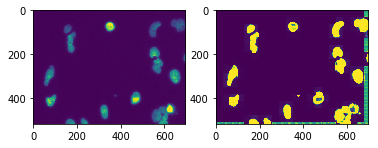

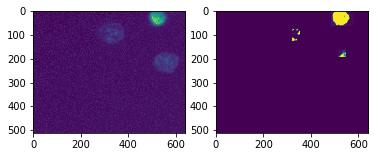

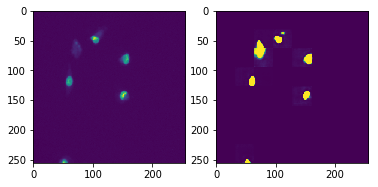

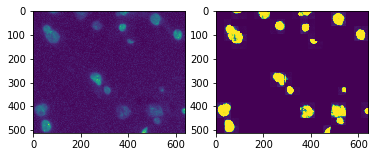

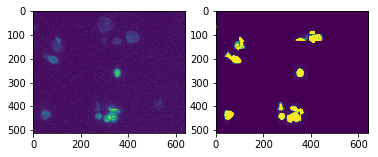

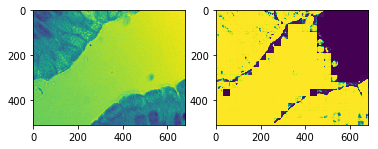

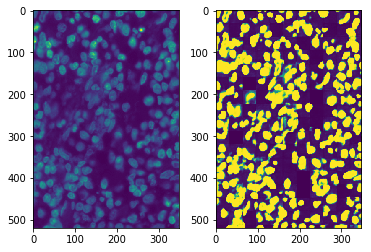

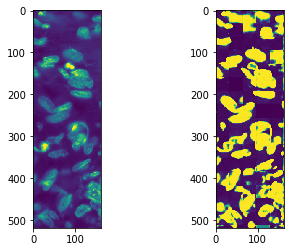

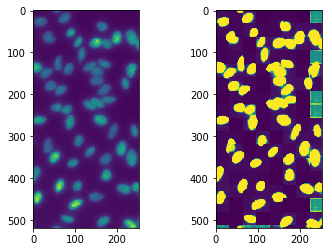

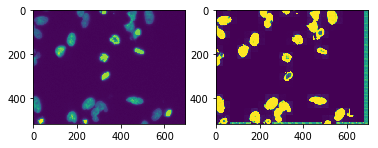

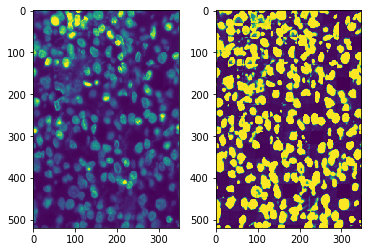

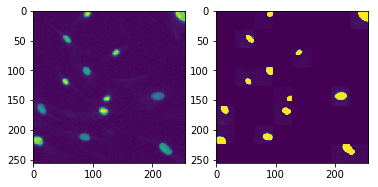

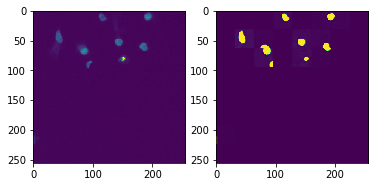

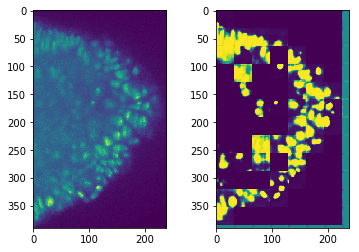

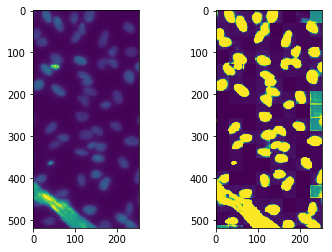

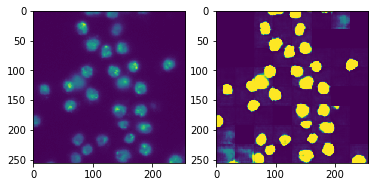

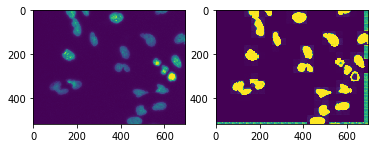

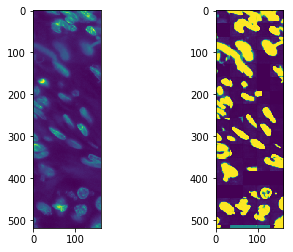

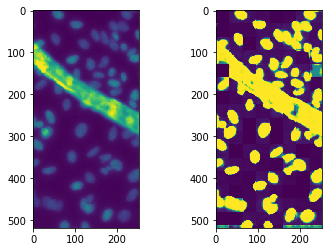

In [94]:
for key in testset_im:
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(testset_im[key])
    f.add_subplot(1,2, 2)
    plt.imshow(output[key])
    plt.show(block=True)

In [48]:
def denoise(img, weight=0.1, eps=1e-3, num_iter_max=200):
    """Perform total-variation denoising on a grayscale image.
    
    Parameters
    ----------
    img : array
        2-D input data to be de-noised.
    weight : float, optional
        Denoising weight. The greater `weight`, the more de-noising (at
        the expense of fidelity to `img`).
    eps : float, optional
        Relative difference of the value of the cost function that determines
        the stop criterion. The algorithm stops when:
            (E_(n-1) - E_n) < eps * E_0
    num_iter_max : int, optional
        Maximal number of iterations used for the optimization.

    Returns
    -------
    out : array
        De-noised array of floats.
    
    Notes
    -----
    Rudin, Osher and Fatemi algorithm.
    """
    u = np.zeros_like(img)
    px = np.zeros_like(img)
    py = np.zeros_like(img)
    
    nm = np.prod(img.shape[:2])
    tau = 0.125
    
    i = 0
    while i < num_iter_max:
        u_old = u
        
        # x and y components of u's gradient
        ux = np.roll(u, -1, axis=1) - u
        uy = np.roll(u, -1, axis=0) - u
        
        # update the dual variable
        px_new = px + (tau / weight) * ux
        py_new = py + (tau / weight) * uy
        norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
        px = px_new / norm_new
        py = py_new / norm_new

        # calculate divergence
        rx = np.roll(px, 1, axis=1)
        ry = np.roll(py, 1, axis=0)
        div_p = (px - rx) + (py - ry)
        
        # update image
        u = img + weight * div_p
        
        # calculate error
        error = np.linalg.norm(u - u_old) / np.sqrt(nm)
        
        if i == 0:
            err_init = error
            err_prev = error
        else:
            # break if error small enough
            if np.abs(err_prev - error) < eps * err_init:
                break
            else:
                e_prev = error
                
        # don't forget to update iterator
        i += 1

    return u

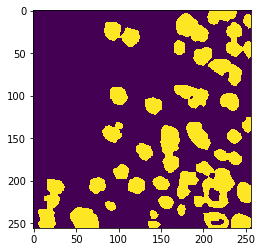

In [207]:
test2 = denoise(output['697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808'],weight=0.35)
test2[test2<0.85]=0
test2[test2>=0.85]=1
plt.imshow(test2,vmin=0,vmax=1)
plt.show()

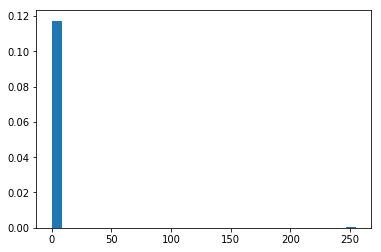

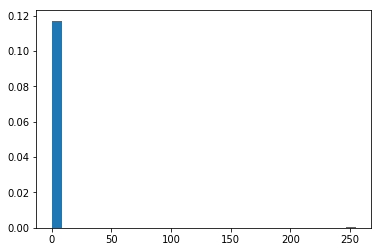

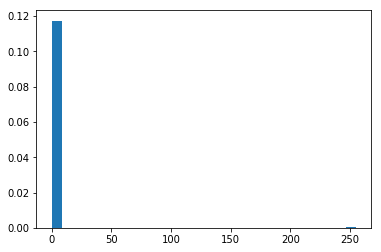

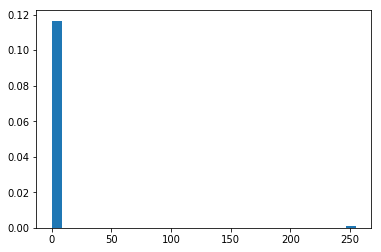

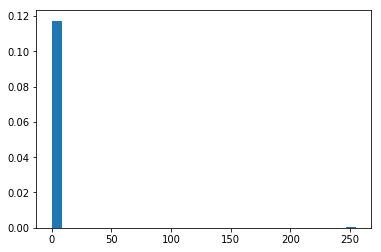

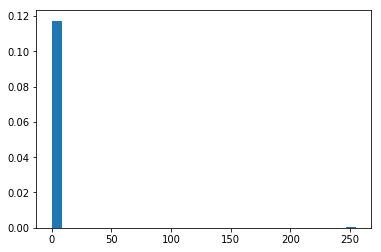

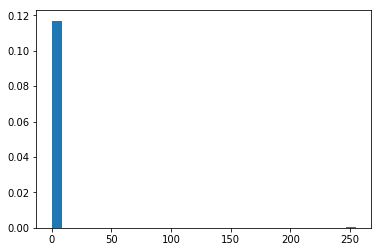

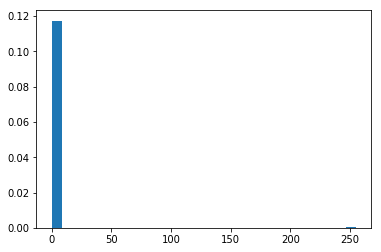

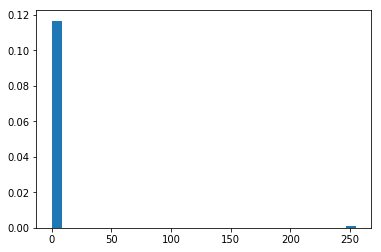

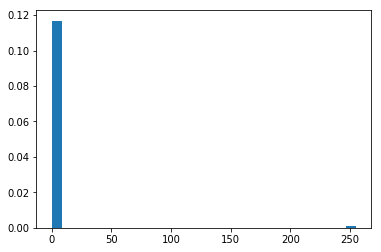

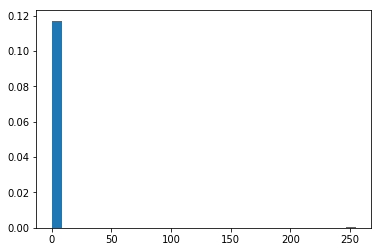

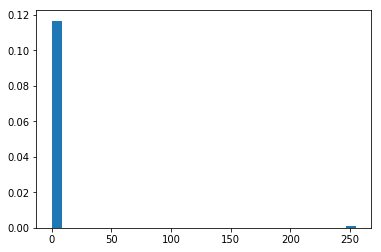

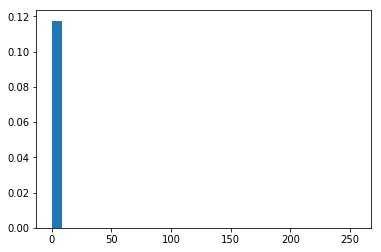

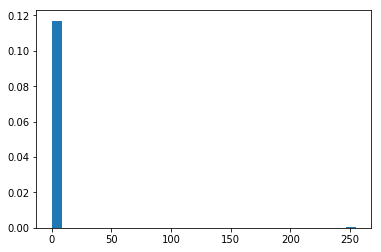

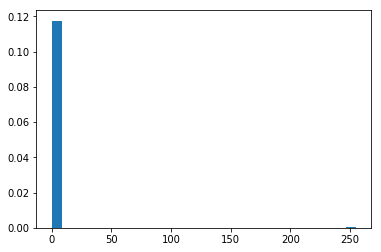

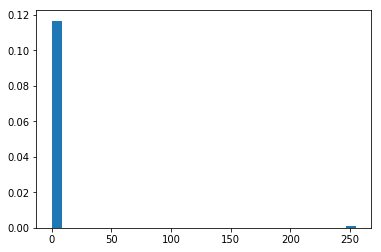

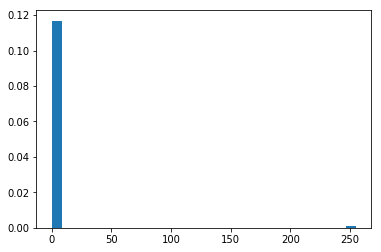

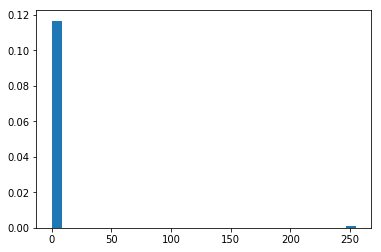

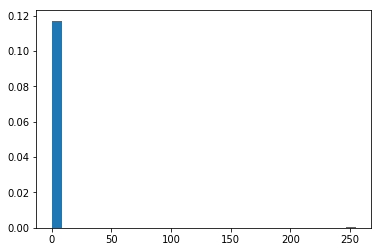

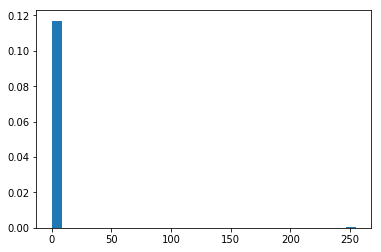

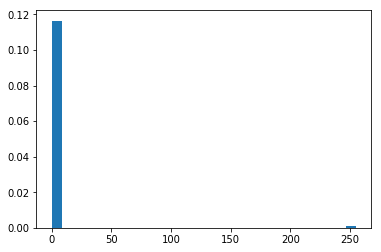

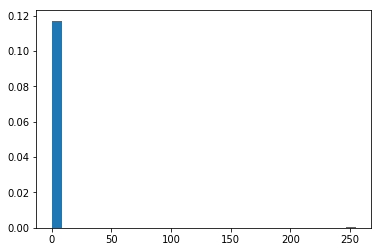

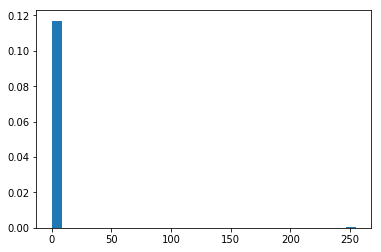

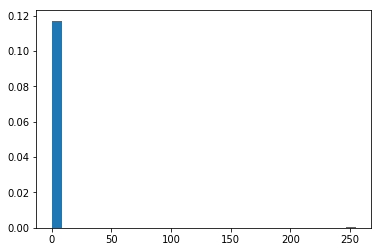

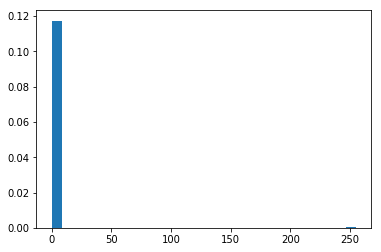

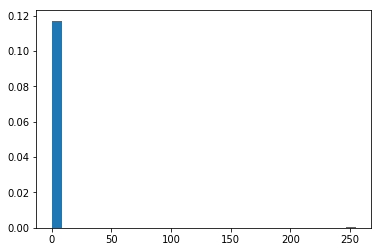

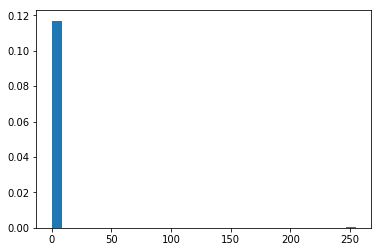

In [73]:
mask_dir = "./data/stage1_train/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9/masks/"
allfiles = os.listdir(mask_dir)
#img = cv2.imread("./data/stage1_train/697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808/masks/")
for img in allfiles:
    img1=cv2.imread(mask_dir+img)
    plt.hist(img1.flatten(), normed=True, bins=30)
    plt.show()

In [74]:
len(output_denoise)

65

In [85]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.88):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [86]:
from skimage.morphology import label

new_test_ids = []
rles = []

for key in output_denoise:
    rle = list(prob_to_rles(output_denoise[key]))
    rles.extend(rle)
    new_test_ids.extend([key] * len(rle))

In [87]:
import pandas as pd

sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-13.csv', index=False)